In [279]:
from pprint import pprint
from collections import Counter
from typing import Callable, Optional, List, Text
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from pyvi import ViTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModel
import torch
import eli5
from eli5.lime import TextExplainer

In [287]:
""" Load data
"""
data = "./data/data.xlsx"
data_df = pd.read_excel(data, engine="openpyxl")
data_df = data_df[2:].reset_index()
train_X = data_df["Sample"].tolist()
train_y = data_df["Intent"].tolist()

# Handle for multilabel case in dataset
tmp_X, tmp_y = [], []
ignore_indices = []
try:
    for i, _ in enumerate(train_X):
        if i not in ignore_indices:
            tmp_X.append(train_X[i])
            tmp = []
            tmp.append(train_y[i])
            for j, _ in enumerate(train_X[i+1:]):
                if j not in ignore_indices:
                    if train_X[i] == train_X[j] and train_y[i] != train_y[j]:
                        tmp.append(train_y[j])
                        ignore_indices.append(j)
                    else:
                        pass
            tmp_y.append(",".join(tmp)) # take advantage the processing logic below
except Exception as e:
    print(e)
    print(tmp)

train_X, train_y = tmp_X.copy(), tmp_y.copy()

### Visualize data

Text(0.5, 0, 'Number of samples')

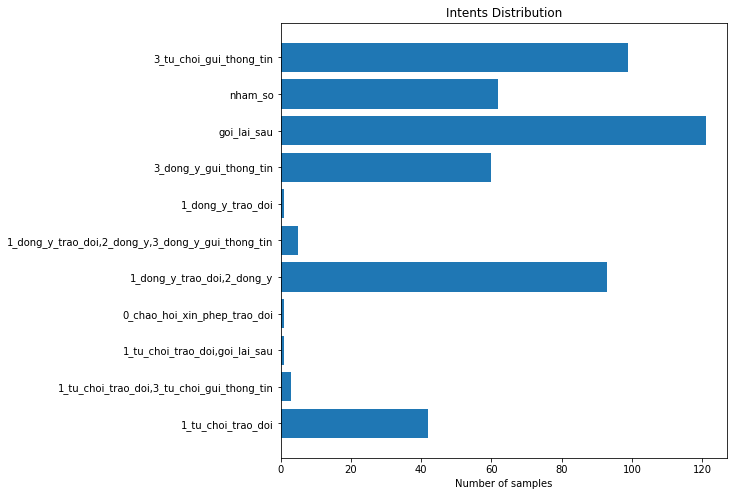

In [288]:
unique_intents = set(data_df["Intent"].tolist())
samples_counter = Counter(tmp_y)
seq_of_nums = list(samples_counter.values())
seq_of_labels = list(samples_counter.keys())

plt.rcParams["figure.figsize"] = [8, 8]
plt.barh(seq_of_labels, seq_of_nums)
plt.title("Intents Distribution")
plt.xlabel("Number of samples")

### Text Augmentation

In [4]:
counter = Counter(tmp_y)
counter

Counter({'1_tu_choi_trao_doi': 45,
         '1_tu_choi_trao_doi,3_tu_choi_gui_thong_tin': 2,
         '1_tu_choi_trao_doi,goi_lai_sau': 1,
         '0_chao_hoi_xin_phep_trao_doi': 1,
         '1_dong_y_trao_doi,2_dong_y': 93,
         '1_dong_y_trao_doi,2_dong_y,3_dong_y_gui_thong_tin': 5,
         '1_dong_y_trao_doi': 1,
         '3_dong_y_gui_thong_tin': 60,
         'goi_lai_sau': 121,
         'nham_so': 62,
         '3_tu_choi_gui_thong_tin': 100})

In [5]:
dict_X = {key: [] for key in counter.keys()}
for utterance, intent in zip(tmp_X, tmp_y):
    dict_X[intent].append(utterance)
print("1_tu_choi_trao_doi,3_tu_choi_gui_thong_tin:\n\t* ", dict_X["1_tu_choi_trao_doi,3_tu_choi_gui_thong_tin"])
print("1_tu_choi_trao_doi,goi_lai_sau:\n\t* ", dict_X["1_tu_choi_trao_doi,goi_lai_sau"])
print("1_dong_y_trao_doi:\n\t* ", dict_X["1_dong_y_trao_doi"])
print("1_dong_y_trao_doi,2_dong_y,3_dong_y_gui_thong_tin:\n\t* ", dict_X["1_dong_y_trao_doi,2_dong_y,3_dong_y_gui_thong_tin"])

1_tu_choi_trao_doi,3_tu_choi_gui_thong_tin:
	*  ['khỏi đi em', 'không có nhu cầu']
1_tu_choi_trao_doi,goi_lai_sau:
	*  ['không có thời gian']
1_dong_y_trao_doi:
	*  ['ừ em']
1_dong_y_trao_doi,2_dong_y,3_dong_y_gui_thong_tin:
	*  ['được', 'được em', 'nói đi', 'ô kê', 'ô kê em']


### Over Sampling (SMOTE)

In [88]:
train_X_res, train_y_res = SMOTE().fit_resample(train_X, train_y)

ValueError: Expected 2D array, got 1D array instead:
array=['anh không có nhu cầu đâu em' 'anh không rảnh nghe chuyện đó'
 'anh nhớ là từ chối dịch vụ bên mình rồi mà em'
 'anh từ chối mấy lần rồi mà' 'anh từ chối nhé đừng hỏi nữa'
 'anh từ chối trao đổi nhé'
 'bên em có nhiêu số để anh chặn hết chứ phiền quá'
 'biết cái gì đâu mà cứ gọi hoài' 'cái gì mà cứ gọi hoài xóa số giùm'
 'chặn số hoài mà vẫn không được mệt ghê' 'có gì đâu trao đổi quài'
 'đã bảo anh không có nhu cầu rồi'
 'đã bảo phiền rồi mà sao cứ liên hệ miết vậy'
 'đã từ chối nhiều lần rồi mà sao cứ phiền phức thế nhỉ'
 'đã từ chối rồi mà sao hỏi với gọi hoài vậy'
 'đừng có gọi nữa nghen mệt quá' 'đừng gọi phiền nữa'
 'gọi nữa báo công an bây giờ đó nghe' 'hỏi hoài không có thấy phiền hả'
 'hỏi hỏi quài' 'khỏi đi em' 'khỏi đi em không cần trao đổi'
 'không cần cũng không có nhu cầu' 'không cần nha' 'không có nhu cầu'
 'không có nhu cầu nên anh từ chối nhé' 'không có nhu cầu trao đổi'
 'không có thời gian' 'không được em giờ bận lắm' 'không rảnh đâu'
 'làm sao để không còn bị làm phiền từ bên của em vậy'
 'sao chặn số bên này rồi mà mãi vẫn có người gọi là sao nhỉ'
 'Thôi đang bận quá nha' 'thôi em ơi' 'thôi không cần'
 'thôi không cần trao đổi gì đâu' 'Thôi mất thời gian quá'
 'thôi mấy này anh biết gì đâu mà trao đổi' 'thôi nha' 'thôi phiền quá'
 'thôi thôi' 'thôi thôi không có cần nhé'
 'trao đổi làm gì đâu có nhu cầu đâu' 'Trời thôi nghe'
 'từ chối nhiều lần lắm rồi nha'
 'từ chối nhiều lần rồi mà sao vẫn cứ gọi vậy'
 'từ chối rồi mà sao hỏi hoài' 'không em' 'xin chào'
 'anh hơi bận nhưng thôi không sao có gì thì nói nhanh đi em'
 'anh nghe đây nói đi' 'cho chị trao đổi á' 'chuyện chi rứa'
 'có chi không' 'Có gì không' 'có gì không em' 'có gì nói đi chị trả lời'
 'cô nói lẹ đi tôi còn bận việc' 'Có việc gì không em' 'có việc gì thế'
 'cứ tự nhiên nói ạ' 'cũng được' 'cũng được em'
 'cũng được tôi cũng đang rảnh' 'dạ' 'dạ chị cứ tự nhiên ạ' 'dạ vâng ạ'
 'đang bận nói nhanh đi em' 'dịch vụ gì vậy' 'đúng vậy' 'được'
 'được được bạn ơi' 'được em' 'được nha' 'được nha chị ừm được nha chị'
 'được nhé' 'em đang nói cái gì đấy' 'em nói đi' 'em nói nhanh lên nhé'
 'gọi chuyện gì thế' 'gọi có chuyện gì thế em' 'lãnh đạo nào đang gọi vậy'
 'lắp đặt gì' 'lẹ đi nha anh đang bận họp nghe' 'lẹ lên'
 'mà có sao không em' 'nghe đây' 'nghe nè nói đi' 'nguyễn kim nào vậy em'
 'nhanh lên' 'nhanh lên chị bận lắm'
 'nhớ là chỉ trao đổi vài phút thôi nhé' 'nói đi' 'nói đi anh nghe đây'
 'nói đi đừng sợ' 'nói đi em' 'nói đi em ơi' 'nói đi tôi nghe'
 'nói lâu không em' 'nói lẹ lẹ đi em' 'nói lẹ lẹ lên' 'nói mau mau nhé'
 'nói nhanh đan trong giờ làm' 'nói nhanh giúp đi' 'nói nhanh lên'
 'nói nhanh nhanh đi nghe' 'nói nhanh nhanh nha' 'nói tiếp đi'
 'nữa hả nói nhanh đi' 'ờ em' 'ô kê' 'ô kê em' 'ờ nói đi'
 'ờ nói đi đang định gọi đây' 'ờ thoải mái' 'ồ vậy nói lẹ đi'
 'phải nói đi' 'rảnh nói đi' 'sao đó' 'sao đó em' 'sao vậy em nói đi'
 'tôi không nhớ chi hết' 'trao đổi gì ạ' 'trao đổi lẹ lên em bận'
 'trình bày đi' 'ừ anh đang bận nên có gì nói lẹ lẹ đi cưng'
 'ừ anh rảnh anh nghe đây' 'ừ chị đây' 'ừ có gì không' 'Ừ được' 'ừ em'
 'ừ mà nhanh lên em nghe' 'ừ nhanh nha em' 'ừ nói' 'ừ nói đi'
 'ừ nói nhanh đi' 'Ừ ok' 'Ừ rồi đánh giá như nào' 'ừ rồi em nói đi'
 'ừ sao em' 'Ừ tui cũng muốn đánh giá đây' 'ừ ừ' 'ừ ừ nói đi nghe nè'
 'ừm được' 'vâng anh nói đi' 'vâng được chứ'
 'vô thẳng vấn đề đi em đừng lòng vòng' 'ừ em' 'anh đồng ý' 'báo giá đi'
 'cảm ơn' 'cho gặp' 'chuyển đi em' 'chuyển máy đi em' 'cũng được'
 'đang cần gấp' 'đang cần thông tin' 'điện lại' 'em cứ gửi đi' 'gọi lại'
 'gọi lại ngay' 'gọi liền' 'gửi anh xem thử' 'gửi anh xem thử nghe'
 'gửi cho anh nha' 'gửi đi' 'gửi đi em' 'gửi qua số này luôn'
 'gửi số này luôn' 'gửi thông tin đi em' 'gửi xem thử' 'kết bạn đi em'
 'nối đi' 'nối đi em' 'nói máy' 'nối máy' 'nối máy đi' 'ò' 'ờ'
 'ờ cũng được' 'ờ em' 'ờ gửi đi' 'ô kê em ơi' 'ô kê nhé' 'ô kê nó' 'ờ ờ'
 'ời' 'ok' 'rồi' 'rồi ô kê' 'số này đây' 'số này đây em' 'số này luôn'
 'tư vấn' 'tư vấn giờ luôn' 'tư vấn thêm' 'ừ được' 'ừ được em' 'ừ gửi'
 'ừ gửi anh xem' 'ừ gửi đi em' 'ừ gửi qua' 'ừ nối' 'ừ ô kê' 'ừ ok'
 'ừ số này' 'ừa' 'ừm em'
 'anh chạy xe ngoài đường có gì chút điện lại nghe em anh cảm ơn'
 'anh đang bận lắm em ơi'
 'anh đang bận việc được không nghe máy lúc này được, em gọi lại sau giờ làm việc nhé'
 'anh đang đưa cháu đi học có gì chút trưa gọi lại em nghe' 'bận'
 'bận lắm' 'bận quá em bữa sau nha' 'bận rồi' 'bận rồi em'
 'bây giờ em bận rồi chị ơi'
 'bên mình cho mình vào lúc khác được không chứ giờ điện thoại mình sắp hết pin rồi'
 'bữa khác' 'bữa khác gọi' 'bữa sau gọi lại nha'
 'cái này em tư vấn cho vợ anh nhé số điện thoại này này'
 'chặp hồi liên lạc nhé giờ anh đang không tiện nghe máy' 'chị đang bận'
 'chiều điện lại' 'chiều gọi' 'chiều gọi lại nhé' 'chiều gọi sau nhé'
 'chiều tối gọi lại' 'chú đang nhậu tí gọi lại nhé' 'chưa rảnh' 'chút gọi'
 'chút gọi lại' 'chút rồi gọi lại'
 'cỡ 15 phút nữa điện lại cho chị được không giờ chị đang dở tay'
 'có gì gọi lại sau nhé' 'có việc rồi' 'đang bận' 'đang bận gọi lại sau'
 'đang bận gọi lại sau đi' 'đang bận gọi lại sau nhé' 'đang bận lắm'
 'đang bận lắm chiều gọi lại' 'đang bận ro òi em gọi sau nhé'
 'Đang bận rồi em' 'đang bị ồn không nghe được' 'đang có công chuyện'
 'đang có việc' 'đang đi ngoài đường'
 'đang đi ngoài đường rồi khi khác liên lạc nhé' 'đang họp' 'Đang họp'
 'đang hộp' 'đang lái xe không tiện nghe' 'đang làm không rảnh'
 'đang ngủ tối điện lại đi' 'đang ồn lắm không nghe được em'
 'đang trong phòng họp' 'để mai mốt gì rãnh rồi gọi lại em nghe'
 'điện lại' 'điện lại được không' 'điện sau' 'đợi một tí' 'đợi một tý'
 'đừng có nói chi nữa đang mệt' 'đừng nói nữa im đi'
 'em đang đi xe chị ơi' 'Em nói gì nghe không được'
 'em ơi chị đang đi giờ không có thời gian nhá'
 'em ơi gọi lại sau giúp chị nhé' 'giờ chị bận rồi em'
 'giờ có việc ra ngoài rồi' 'giờ không tiện nghe' 'gọi cho anh sau'
 'gọi lại' 'gọi lại sau' 'Gọi lại sau đi' 'gọi lại sau đi đang mệt'
 'gọi lại sau nha' 'gọi sau' 'gọi sau đi' 'gọi sau nha' 'gọi sau nha em'
 'hiện anh đang hơi bận á' 'hôm khác gọi lại' 'hôm khác gọi nhé bận rồi'
 'hôm khác nha chưa bận' 'im đi đừng nói nữa' 'khi khác đi'
 'khi khác đi mệt quá' 'khi khác gọi' 'khi khác mệt muốn chết'
 'khi khác rồi gọi' 'khoảng một tiếng nữa gọi lại cho mình nhé'
 'không có rảnh' 'không nghe được' 'không rảnh lắm' 'không tiện'
 'không tiện nghe' 'lát gọi lại' 'liên lạc ngoài giờ hành chính giúp mình'
 'lúc khác đi' 'mắc chuyện' 'mai gọi lại' 'mai gọi nha' 'một đang bận họp'
 'nói gì nghe không rõ' 'Nói gì nghe không rõ'
 'ờ đang họp rồi mai điện lại đi' 'ô kê mà xíu nữa gọi lại được không'
 'sáng mai gọi' 'Thôi đang bận lắm lúc khác đi' 'thôi đừng có hỏi chi nữa'
 'thôi đừng có hỏi gì hết gọi hoài' 'Thôi giờ anh bận lắm' 'tí gọi lại'
 'ti gọi lại nha' 'tôi đâu có rảnh mà nói chuyện' 'tối gọi lại'
 'tôi không rảnh mà trao đổi' 'tôi mệt quá gọi lại sau đi'
 'trao đổi gì đang bận muốn chết'
 'trao đổi gì rảnh quá trao đổi với mấy người' 'trao đổi sau'
 'ừ chị đang bận lát gọi lại' 'ừ gọi sau nha' 'xí gọi lại' 'xí nữa'
 'à anh dùng số này để gọi cho hàng xóm thôi nên anh không biết'
 'ai biết đâu nhầm số rồi' 'bên mình nhầm số rồi'
 'chứ không phải văn út đâu' 'Dạ không phải đâu chị ơi'
 'Dạ nhầm người rồi chị' 'điện miết rứa điên hả' 'đừng có điện nữa'
 'đừng điện nữa nhầm người rồi' 'đừng gọi nữa bực mình quá'
 'em là ân chứ không phải bảo nha' 'em là vi chứ không phải ân đâu'
 'gọi gì gọi hoài vậy bây' 'hông em' 'Hùng nào ở đây không phải đâu'
 'không' 'không biết' 'không biết ai hết em' 'không có anh nào ở đây cả'
 'không nha em ơi' 'không nhầm rồi' 'không phải' 'không phải em ơi'
 'Không phải không phải' 'không phải Nam lộn rồi' 'không phải nghe'
 'không phải nha lộn số rồi' 'không phải rồi em' 'lộn máy rồi nha'
 'lộn người rồi' 'Lộn người rồi hỉ' 'lộn rồi' 'lộn số' 'lộn số rồi'
 'lộn số rồi em ơi' 'nhầm chố rồi' 'nhầm máy' 'nhầm máy em' 'nhầm máy rồi'
 'nhầm rồi nha' 'nhầm số' 'nhầm số rồi' 'Nhầm số rồi'
 'nhầm số rồi má ơi điện gì mà ngày nào cũng điện' 'sai số' 'sai số rồi'
 'sai số rồi nha' 'sao gọi miết vậy' 'số này không phải của út nào hết'
 'số ni của Kiên mà' 'Số Thành chớ Út nào' 'tắt máy đi mệt quá'
 'tôi không muốn nghe' 'tôi là nữ mà anh nào'
 'từ nay đừng gọi nữa nghe phiền quá' 'Tui là Minh không phải Út'
 'ủa Khánh nào em chị là Tuấn mà lộn số rồi em ơi' 'ủa Mỹ nào Tuấn đây'
 'ủa số ni của Thảo mà chị' 'Út là ai không biết'
 'út là ai mà sao gọi cho tôi hoài vậy' 'út nào ở đây mà út'
 'anh bận lắm không có thời gian đâu' 'anh biết rồi không cần đâu'
 'anh không có nhu cầu' 'bận lắm' 'cảm ơn em anh không có nhu cầu'
 'cần chị gọi lại' 'chị bận lắm' 'chị bận việc rồi đó em'
 'chị đang bận rồi' 'chị không có điều kiện' 'chị không có nhu cầu'
 'chị không đầu tư em ạ' 'cô vít mà đầu tư gì' 'đã bảo không cần rồi'
 'Đã nói là thôi mà' 'đang mệt đừng điện nữa' 'để coi lại'
 'để khi khác nha' 'dẹp đi' 'dịch dã mà mời làm gì'
 'điện miết rứa điên hả' 'đừng điện nữa' 'đừng gọi nữa'
 'đừng gọi nữa bực mình' 'đừng gọi tui nữa phiền quá' 'đừng làm phiền'
 'gọi gì gọi hoài vậy bây' 'gọi hoài' 'hết tiền rồi'
 'hiện tại bận nha em không có rảnh' 'học nhiều rồi em' 'hôm cần' 'hông'
 'hông cần' 'hổng cần' 'hông có nhu cầu' 'hổng có nhu cầu' 'im đi mệt quá'
 'khi nào cần anh liên hệ em' 'khỏi' 'khỏi cần' 'khỏi đi' 'khỏi nha'
 'không' 'không cần' 'không cần đâu' 'không có rảnh' 'không có tiền'
 'không có tiền học đâu' 'không đầu tư' 'không dùng' 'không được'
 'không được em ơi' 'không em' 'không em nha' 'không em ơi' 'không ham'
 'không mua' 'không nha' 'không nha em' 'Không nhé' 'không nhu cầu'
 'không quan tâm' 'không rảnh' 'không rảnh em' 'không tiện'
 'làm phiền quá' 'mấy cái tào lao đừng điện nữa' 'nghèo lắm'
 'ờ nhưng mà giờ anh chưa cần đâu' 'phiền lắm' 'phiền phức' 'phiền quá'
 'sao gọi miết vậy' 'tào lao' 'tắt máy đi mệt quá' 'thôi'
 'thôi anh cảm ơn nha' 'thôi anh không cần đâu' 'thôi được rồi'
 'thôi được rồi lúc nào cần anh liên hệ' 'thôi em' 'thôi em ơi'
 'thôi im đi' 'thôi khỏi đi em' 'thôi khỏi em' 'thôi không cần đâu'
 'Thôi không cần đâu' 'thôi không cần tư vấn đâu' 'thôi nha' 'thôi nhé'
 'thôi thôi' 'Thôi thôi' 'thôi tư vấn chi nữa' 'tiền đâu mua'
 'tôi không muốn nghe' 'từ nay đừng có gọi nữa nghe phiền quá'
 'ừ không em' 'ừ thôi anh không cần' 'xóa số của tôi đi'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Model

In [215]:
""" Prepare multilabel format for training with Sklearn
"""
# Get unique labels from dataset
# for label binarizer
classes = set()
for label in train_y:
    tmp_lbl = label.split(",")
    for t in tmp_lbl:
        classes.add(t)
classes = list(classes)
mlb = MultiLabelBinarizer(classes=classes)

# Binarize label
train_y = mlb.fit_transform([tuple(l.split(",")) for l in train_y])

In [216]:
print(f"Intents:\n\n{classes}\n")
print(f"Number of Intents: {len(classes)}")

Intents:

['1_dong_y_trao_doi', '2_dong_y', '1_tu_choi_trao_doi', 'goi_lai_sau', '0_chao_hoi_xin_phep_trao_doi', '3_tu_choi_gui_thong_tin', '3_dong_y_gui_thong_tin', 'nham_so']

Number of Intents: 8


In [8]:
""" Feature Extraction
"""
def _tokenize(text):
    return ViTokenizer.tokenize(text).split()

vectorizer = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b",
    tokenizer=_tokenize,
    ngram_range=(1, 2),
    sublinear_tf=True
)

# scaler = StandardScaler(with_mean=False)
scaler = MaxAbsScaler()

In [27]:
""" PhoBERT's Feature Extractor
"""
phobert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base",
                                                             output_hidden_states=True)
pho_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [ ]:
def phonizer(text):
    tokenized_text = ViTokenizer.tokenize(text.lower())
    encoded_text = pho_tokenizer(tokenized_text,
                                 padding="max_length",
                                 truncation=True,
                                 return_tensors="pt")
    return encoded_text

In [69]:
def _get_embedding(encoded_text, model):
    embedding = model(**encoded_text).hidden_states[0].squeeze()[0, :]
    return embedding

In [70]:
X_embeddings = []
try:
    for utterance in train_X:
        encoded_utterance = phonizer(utterance)
        embedding = _get_embedding(encoded_utterance, phobert)
        X_embeddings.append(embedding)
except Exception as e:
    print(f"error: {e}")
    pass
finally:
    X_embeddings = np.array(X_embeddings)

In [72]:
X_embeddings.shape

(491,)

In [62]:
example = tmp_X[0]
with torch.no_grad():
    outputs = phobert(**phonizer(example))
    embedding = outputs.hidden_states[0].squeeze()[0, :]
    print(embedding)

tensor([-3.8863e-02, -4.0548e-02, -7.1410e-02,  1.3363e-02, -1.5956e-02,
         4.9345e-02, -1.2071e-01, -4.1689e-01, -6.0606e-02,  5.8785e-03,
        -3.6366e-02, -7.6291e-02, -4.6499e-02, -8.9318e-02, -1.5102e-01,
        -4.5533e-03, -2.0530e-02, -4.7825e-02,  6.0319e-02,  1.0778e-02,
         2.2066e-01, -9.7644e-02, -6.2739e-02, -5.2497e-02, -1.5277e-01,
         1.8341e-02,  1.2768e-01, -9.5282e-02,  1.7937e-02, -2.3020e-01,
        -1.4433e-01,  1.3502e+00, -1.5079e-02, -5.0338e-02, -1.3446e-01,
        -6.6456e-02,  1.4929e-01, -1.6731e-01, -8.9195e-02, -7.8172e-02,
        -9.5498e-02, -3.0392e-02, -7.7869e-02, -2.6837e-02,  8.5760e-02,
        -2.6499e-02, -1.4737e-01, -7.2714e-03,  1.6423e-01, -3.7569e-02,
        -3.0401e-02, -6.3056e-02, -2.8512e-03, -2.7570e-02, -5.7113e-01,
         3.6379e-03, -5.5248e-02,  4.1156e-03,  7.9112e-03,  6.0023e-02,
        -9.9393e-02,  9.8468e-02, -5.9979e-02, -3.9280e-02,  9.9481e-01,
        -1.9937e-03,  2.9351e-02, -1.5972e-01,  1.2

In [217]:
""" Build classifier which enables multilabel capability
"""
RANDOM_STATE = 42
NUM_CPU = 8
estimator = SVC(kernel='linear',
                random_state=RANDOM_STATE,
                verbose=1,
                probability=True,
                class_weight=None)
classifier = MultiOutputClassifier(estimator, n_jobs=NUM_CPU)
pipe = make_pipeline(
    vectorizer,
#     scaler,
    classifier
)
params = {
    "multioutputclassifier__estimator__C": [1e-4, 1e-3, 1e-2, 0.1, 1],
#     "multioutputclassifier__estimator__class_weight": ["balanced", None],
#     "tfidfvectorizer__analyzer": ["char", "word"],
#     "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 3)],
#     "tfidfvectorizer__max_df": [0.25, 0.33, 0.5, 0.75, 1],
#     "tfidfvectorizer__sublinear_tf": [True, False]
}
gs = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring="f1_micro",
    n_jobs=NUM_CPU,
    cv=5,
    verbose=3,
    error_score=0.,
    refit=True,
    return_train_score=True
)
gs.fit(train_X, train_y)
model = gs.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
*
optimization finished, #iter = 39
obj = -0.007799, rho = 0.999876
nSV = 78, nBSV = 78
Total nSV = 78
*
optimization finished, #iter = 34
obj = -0.006800, rho = 0.999965
nSV = 68, nBSV = 68
Total nSV = 68
*
optimization finished, #iter = 40
obj = -0.007999, rho = 0.999915
nSV = 80, nBSV = 80
Total nSV = 80
*
optimization finished, #iter = 52
obj = -0.010399, rho = 0.999850
nSV = 104, nBSV = 104
Total nSV = 104
*
optimization finished, #iter = 41
obj = -0.008199, rho = 0.999922
nSV = 82, nBSV = 82
Total nSV = 82
*
optimization finished, #iter = 35
obj = -0.006999, rho = 0.999931
nSV = 70, nBSV = 70
Total nSV = 70
*
optimization finished, #iter = 52
obj = -0.010399, rho = 0.999862
nSV = 104, nBSV = 104
Total nSV = 104
*
optimization finished, #iter = 36
obj = -0.007199, rho = 0.999934
nSV = 72, nBSV = 72
Total nSV = 72
*
optimization finished, #iter = 97
obj = -0.019397, rho = 0.999864
nSV = 194, nBSV = 194
Total nSV = 194
*
op


optimization finished, #iter = 125
obj = -0.157856, rho = 0.999275
nSV = 173, nBSV = 143
obj = -0.193759, rho = 0.999034
nSV = 213, nBSV = 175
Total nSV = 173
Total nSV = 213
*
optimization finished, #iter = 162
obj = -1.033474, rho = 0.995228
nSV = 188, nBSV = 64
Total nSV = 188
*
optimization finished, #iter = 126
obj = -0.715881, rho = 0.997844
nSV = 152, nBSV = 42
Total nSV = 152
*
optimization finished, #iter = 142
obj = -0.993158, rho = 0.996757
nSV = 176, nBSV = 62
Total nSV = 176
**
optimization finished, #iter = 131

optimization finished, #iter = 104
obj = -0.735480, rho = 0.997557
obj = -0.157856, rho = 0.999256
nSV = 155, nBSV = 44
nSV = 173, nBSV = 143
Total nSV = 155
Total nSV = 173
*
optimization finished, #iter = 184
obj = -1.918038, rho = 0.991351
nSV = 251, nBSV = 145
Total nSV = 251
*
optimization finished, #iter = 102
*obj = -0.159848, rho = 0.999202
nSV = 174, nBSV = 146
Total nSV = 174

optimization finished, #iter = 186
obj = -1.589351, rho = 0.993794
nSV = 237,

*
optimization finished, #iter = 185
obj = -7.517870, rho = 0.975549
nSV = 166, nBSV = 48
Total nSV = 166
*
optimization finished, #iter = 277
obj = -14.935670, rho = 0.937801
nSV = 243, nBSV = 112
Total nSV = 243
*
optimization finished, #iter = 203
obj = -6.608743, rho = 0.981036
nSV = 173, nBSV = 42
Total nSV = 173
*
optimization finished, #iter = 176
obj = -7.312755, rho = 0.977536
nSV = 165, nBSV = 47
Total nSV = 165
*
optimization finished, #iter = 235
obj = -9.651619, rho = 0.967652
nSV = 202, nBSV = 66
Total nSV = 202
*
optimization finished, #iter = 262
obj = -9.812203, rho = 0.951941
nSV = 215, nBSV = 61
Total nSV = 215
*
optimization finished, #iter = 266
obj = -17.044365, rho = 0.919212
nSV = 260, nBSV = 141
Total nSV = 260
*
optimization finished, #iter = 209
obj = -7.916191, rho = 0.976341
nSV = 178, nBSV = 52
Total nSV = 178
*
optimization finished, #iter = 213
obj = -6.471025, rho = 0.981485
nSV = 173, nBSV = 40
Total nSV = 173
**
optimization finished, #iter = 247

opt

*
optimization finished, #iter = 205
obj = -1.492851, rho = 0.985741
nSV = 175, nBSV = 1
Total nSV = 175
*
optimization finished, #iter = 181
obj = -14.641289, rho = 0.923093
nSV = 112, nBSV = 10
Total nSV = 112
*
optimization finished, #iter = 303
obj = -43.581563, rho = 0.711757
nSV = 176, nBSV = 33
Total nSV = 176
*
optimization finished, #iter = 303
obj = -43.581563, rho = 0.711757
nSV = 176, nBSV = 33
Total nSV = 176
*.*.*
optimization finished, #iter = 360
obj = -53.272467, rho = 0.911858
nSV = 195, nBSV = 40
Total nSV = 195
*.*
optimization finished, #iter = 422
obj = -104.398820, rho = 0.549996
nSV = 247, nBSV = 93
Total nSV = 247
*
optimization finished, #iter = 398
obj = -73.467770, rho = 0.626385
nSV = 226, nBSV = 60
Total nSV = 226
*
optimization finished, #iter = 147
obj = -9.991356, rho = 0.941654
nSV = 106, nBSV = 7
Total nSV = 106
*.*
optimization finished, #iter = 204
obj = -1.493011, rho = 0.986052
nSV = 168, nBSV = 1
Total nSV = 168
*
optimization finished, #iter = 3

*.*.*
optimization finished, #iter = 402
obj = -71.393414, rho = 0.685029
nSV = 246, nBSV = 63
Total nSV = 246
*
optimization finished, #iter = 589
obj = -67.524825, rho = 0.675535
nSV = 251, nBSV = 54
Total nSV = 251
*
optimization finished, #iter = 320
obj = -50.613782, rho = 0.972510
nSV = 192, nBSV = 39
Total nSV = 192
**.
optimization finished, #iter = 227
obj = -1.494086, rho = 0.988208
nSV = 193, nBSV = 1
Total nSV = 193
*
optimization finished, #iter = 371
obj = -47.225261, rho = 0.836154
nSV = 211, nBSV = 33
Total nSV = 211
*.*
optimization finished, #iter = 493
obj = -107.024373, rho = 0.697828
nSV = 281, nBSV = 89
Total nSV = 281
*.*
optimization finished, #iter = 559
obj = -54.625246, rho = 0.733585
nSV = 236, nBSV = 37
Total nSV = 236
*
optimization finished, #iter = 499
obj = -77.478458, rho = 0.711504
nSV = 268, nBSV = 55
Total nSV = 268
*.*
optimization finished, #iter = 427
obj = -64.425553, rho = 0.698162
nSV = 230, nBSV = 48
Total nSV = 230
*.*
optimization finished,

/home/buihuy/Intent-Detection/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/buihuy/Intent-Detection/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/buihuy/Intent-Detection/venv/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/buihuy/Intent-Detection/venv/lib/python3.7/site-packages/sklearn/multioutput.py", lin

In [218]:
gs.cv_results_["mean_test_score"]

array([0.        , 0.        , 0.        , 0.        , 0.19745506])

In [219]:
gs.cv_results_["mean_train_score"]

array([0.        , 0.        , 0.        , 0.03471832, 0.54995882])

In [220]:
""" Show Best Parameters
"""
pprint(gs.cv_results_)
print(f"best estimator: {gs.best_estimator_}")
print(f"best params: {gs.best_params_}")
print(f"best score: {gs.best_score_}")

{'mean_fit_time': array([0.12377605, 0.12560892, 0.12787108, 0.12933331, 0.1276947 ]),
 'mean_score_time': array([0.06399188, 0.06542068, 0.06864762, 0.06573267, 0.06391673]),
 'mean_test_score': array([0.        , 0.        , 0.        , 0.        , 0.19745506]),
 'mean_train_score': array([0.        , 0.        , 0.        , 0.03471832, 0.54995882]),
 'param_multioutputclassifier__estimator__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'multioutputclassifier__estimator__C': 0.0001},
            {'multioutputclassifier__estimator__C': 0.001},
            {'multioutputclassifier__estimator__C': 0.01},
            {'multioutputclassifier__estimator__C': 0.1},
            {'multioutputclassifier__estimator__C': 1}],
 'rank_test_score': array([2, 2, 2, 2, 1], dtype=int32),
 'split0_test_score': array([0., 0., 0., 0., 0.]),
 'split0_train_score': array([0., 0., 0., 

#### Eli5

In [184]:
model

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w+\\b',
                                 tokenizer=<function _tokenize at 0x7f823ed270e0>)),
                ('maxabsscaler', MaxAbsScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=SVC(C=1, kernel='linear',
                                                     probability=True,
                                                     random_state=42,
                                                     verbose=1),
                                       n_jobs=8))])

In [145]:
input = model.named_steps["tfidfvectorizer"].transform(["anh không có nhu cầu đâu em"])

In [61]:
input = model.named_steps["maxabsscaler"].transform(input)

In [222]:
tmp_models = model.named_steps["multioutputclassifier"].estimators_

In [68]:
tmp_models[2].predict_proba(input)

array([[0.05047908, 0.94952092]])

In [230]:
_clf = tmp_models[5]
def _predict_proba(texts: List[Text],
                   preprocessing: Optional[Callable] = None):
    if not isinstance(texts, List):
        texts = [texts]

    if preprocessing:
        texts = preprocessing(texts)

    inputs = model.named_steps["tfidfvectorizer"].transform(texts)
#     inputs = model.named_steps["maxabsscaler"].transform(inputs)
    ret = _clf.predict_proba(inputs)

    return ret

In [255]:
texts = ["đang bận rồi"]
_predict_proba(texts=texts,
               preprocessing=lambda x: [ViTokenizer.tokenize(text.lower())
                                        for text in texts])

array([[0.94775869, 0.05224131]])

In [286]:
model.predict_proba([
    "cảm ơn em anh không có nhu cầu",
    "dẹp đi",
    "đừng điện nữa",
    "đừng điện đừng điện nữa"
])

[array([[0.98175322, 0.01824678],
        [0.96515584, 0.03484416],
        [0.97885723, 0.02114277],
        [0.97624319, 0.02375681]]),
 array([[0.98275432, 0.01724568],
        [0.96490708, 0.03509292],
        [0.97942991, 0.02057009],
        [0.97690387, 0.02309613]]),
 array([[0.94933026, 0.05066974],
        [0.96037286, 0.03962714],
        [0.96409449, 0.03590551],
        [0.96829034, 0.03170966]]),
 array([[0.96344258, 0.03655742],
        [0.96302458, 0.03697542],
        [0.97154826, 0.02845174],
        [0.96221578, 0.03778422]]),
 array([[0.9961117 , 0.0038883 ],
        [0.99653773, 0.00346227],
        [0.99653343, 0.00346657],
        [0.99653178, 0.00346822]]),
 array([[0.20613232, 0.79386768],
        [0.38876132, 0.61123868],
        [0.43152045, 0.56847955],
        [0.42555187, 0.57444813]]),
 array([[0.95377585, 0.04622415],
        [0.95372058, 0.04627942],
        [0.95644717, 0.04355283],
        [0.95287862, 0.04712138]]),
 array([[0.97232865, 0.02767135],


In [284]:
texts = "đừng điện nữa"
te = TextExplainer(vec=model["tfidfvectorizer"], random_state=42)
te.fit(texts, _predict_proba)
te.show_prediction(target_names=["NON 3_tu_choi_gui_thong_tin", "3_tu_choi_gui_thong_tin"])

In [285]:
texts = "đừng điện đừng điện nữa"
te = TextExplainer(vec=model["tfidfvectorizer"], random_state=42)
te.fit(texts, _predict_proba)
te.show_prediction(target_names=["NON 3_tu_choi_gui_thong_tin", "3_tu_choi_gui_thong_tin"])

In [228]:
model.predict(["học nhiều rồi em"])

array([[0, 0, 0, 0, 0, 1, 0, 0]])

### Evaluate on Train Set

In [226]:
""" Training Evaluation
"""
y_pred = model.predict(train_X)
y_true = train_y
f1_micro = f1_score(y_true, y_pred, average="micro")
f1_macro = f1_score(y_true, y_pred, average="macro")
acc = accuracy_score(y_true, y_pred)
print(f"f1 micro: {f1_micro:.2f}")
print(f"f1 macro: {f1_macro:.2f}")
print(f"accuracy: {acc:.2f}")

f1 micro: 0.90
f1 macro: 0.89
accuracy: 0.83
[CV 1/5] END multioutputclassifier__estimator__C=0.001;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END multioutputclassifier__estimator__C=0.1;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END multioutputclassifier__estimator__C=1;, score=(train=0.000, test=0.000) total time=   0.0s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 2/5] END multioutputclassifier__estimator__C=0.0001;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 5/5] END multioutputclassifier__estimator__C=0.01;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][CV 4/5] END multioutputclassifier__estimator__C=0.0001;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END multioutputclassifier__estimator__C=0.001;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END multioutputclassifier__estimator__C=0.01;, score=(train

In [14]:
print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=1))

                              precision    recall  f1-score   support

           1_dong_y_trao_doi       0.98      0.95      0.96        99
                    2_dong_y       0.98      0.94      0.96        98
          1_tu_choi_trao_doi       1.00      0.88      0.93        48
                 goi_lai_sau       0.96      0.99      0.98       122
0_chao_hoi_xin_phep_trao_doi       1.00      1.00      1.00         1
     3_tu_choi_gui_thong_tin       0.93      0.91      0.92       102
      3_dong_y_gui_thong_tin       0.95      0.91      0.93        65
                     nham_so       1.00      0.89      0.94        62

                   micro avg       0.97      0.93      0.95       597
                   macro avg       0.97      0.93      0.95       597
                weighted avg       0.97      0.93      0.95       597
                 samples avg       0.97      0.93      0.94       597



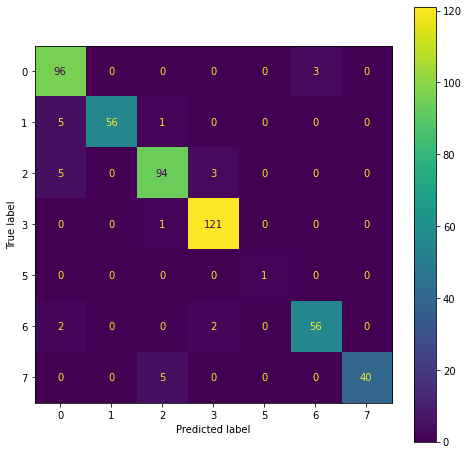

In [147]:
ConfusionMatrixDisplay.from_predictions(y_true.argmax(axis=1), y_pred.argmax(axis=1))

### Evaluate on Test Set

In [16]:
test_df = pd.read_excel("./data/Lỗi Voicebot V2.xlsx", engine="openpyxl", sheet_name="Intent_test")
test_X = test_df["Transcript"].tolist()
test_y = test_df["Expected Intent Token"].tolist()
test_y = mlb.transform([[label] for label in test_y])

In [17]:
preds = model.predict(test_X)
acc = accuracy_score(test_y, preds)
f1_micro = f1_score(test_y, preds, average="micro")
f1_macro = f1_score(test_y, preds, average="macro")
print(f"f1 micro: {f1_micro:.2f}")
print(f"f1 macro: {f1_macro:.2f}")
print(f"accuracy: {acc:.2f}")

f1 micro: 0.17
f1 macro: 0.16
accuracy: 0.10


/home/buihuy/Intent-Detection/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 3/5] END multioutputclassifier__estimator__C=0.0001;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 4/5] END multioutputclassifier__estimator__C=0.01;, score=(train=0.000, test=0.000) total time=   0.1s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 2/5] END multioutputclassifier__estimator__C=0.1;, score=(train=0.645, test=0.358) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 5/5] END multioutputclassifier__estimator__C=0.0001;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 5/5] END multioutputclassifier__estimator__C=0.01;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 2/5] END multioutputclassifier__estimator__C=0.0001;, score=(train

In [133]:
print(classification_report(test_y, preds, target_names=mlb.classes_, zero_division=1))

                              precision    recall  f1-score   support

           1_dong_y_trao_doi       1.00      0.33      0.50         3
                     nham_so       0.00      1.00      0.00         0
     3_tu_choi_gui_thong_tin       0.00      1.00      0.00         0
                 goi_lai_sau       1.00      0.40      0.57         5
                    2_dong_y       0.00      1.00      0.00         0
0_chao_hoi_xin_phep_trao_doi       1.00      1.00      1.00         0
      3_dong_y_gui_thong_tin       0.00      1.00      0.00         0
          1_tu_choi_trao_doi       1.00      0.16      0.28        31

                   micro avg       0.24      0.21      0.22        39
                   macro avg       0.50      0.74      0.29        39
                weighted avg       1.00      0.21      0.33        39
                 samples avg       0.37      0.21      0.18        39

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 1/5] END multioutputclassifier__est

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 1/5] END multioutputclassifier__estimator__C=0.001;, score=(train=0.000, test=0.000) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 1/5] END multioutputclassifier__estimator__C=0.01;, score=(train=0.000, test=0.000) total time=   0.1s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 3/5] END multioutputclassifier__estimator__C=0.01;, score=(train=0.959, test=0.426) total time=   0.2s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 4/5] END multioutputclassifier__estimator__C=1;, score=(train=0.000, test=0.000) total time=   0.1s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 4/5] END multioutputclassifier__estimator__C=0.0001, multioutputclassifier__estimator__class_weight=balanced;, score=(train=0.000, test=0.000) total time=   0.1s
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][CV 4/5] END multioutputclassifier__estimator__C=0.0001, multiou

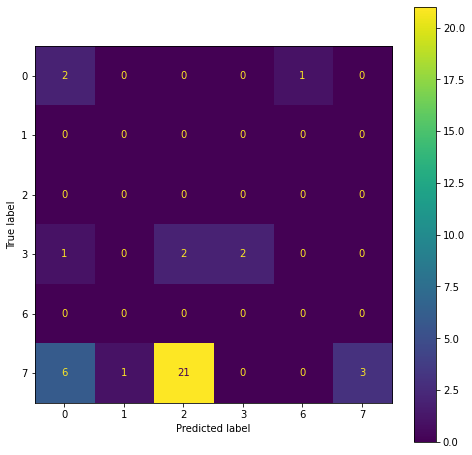

In [144]:
ConfusionMatrixDisplay.from_predictions(test_y.argmax(axis=1), preds.argmax(axis=1))

In [143]:
preds.argmax(axis=1)

array([2, 2, 0, 2, 7, 2, 7, 2, 2, 0, 2, 3, 3, 2, 0, 2, 2, 2, 1, 2, 2, 2,
       0, 2, 2, 0, 0, 7, 0, 2, 2, 0, 0, 2, 6, 2, 2, 2, 2])

### Single Testing

In [65]:
test_x = ["rồi"]
predicted_results = model.predict(test_x)
# print(predicted_results)
# print(np.where(predicted_results == 1)[1])
mlb.inverse_transform(predicted_results)

[()]